In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import struct

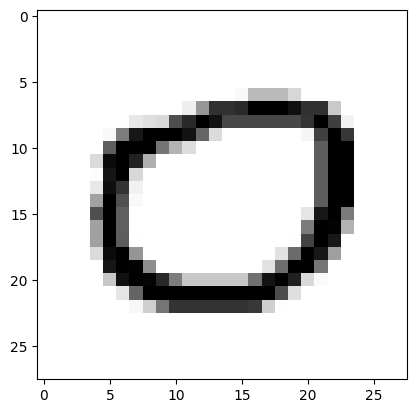

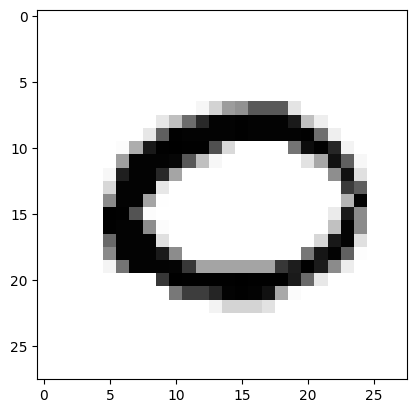

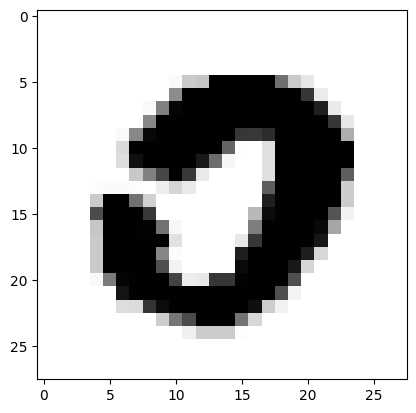

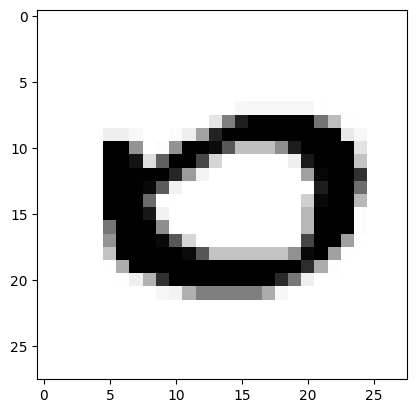

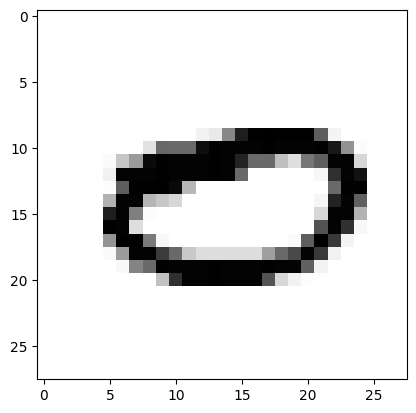

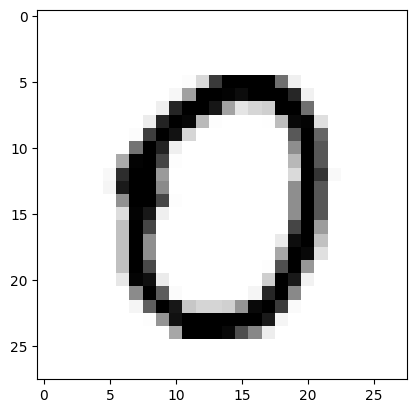

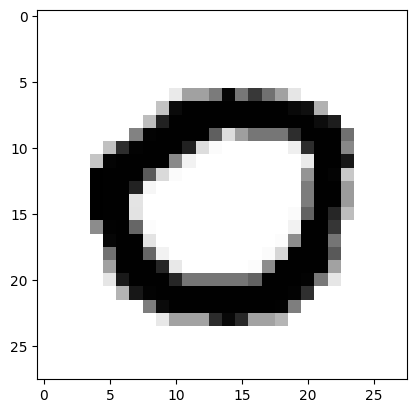

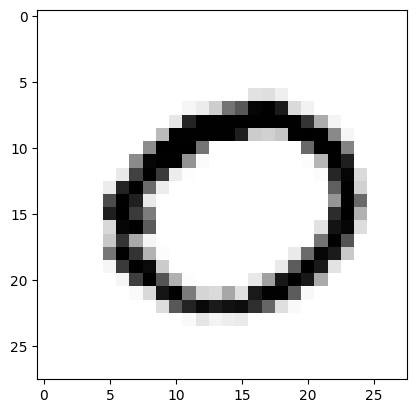

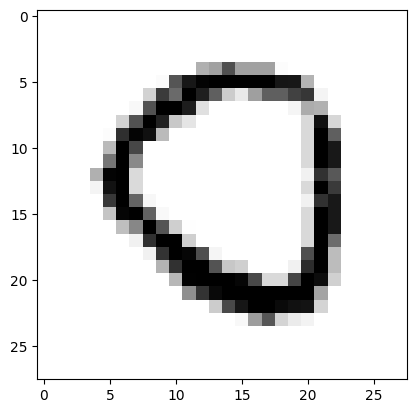

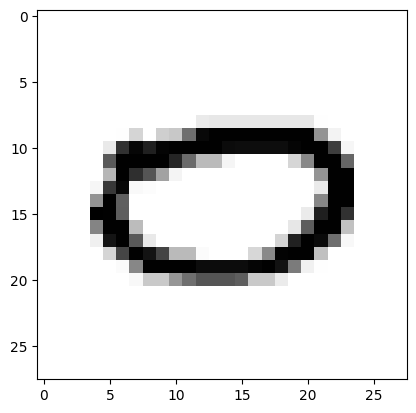

In [40]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt('../HW2_material/MNISTnumImages5000_balanced.txt', dtype=float)

fac = 0.99 / 255 # to avoid 0
train_imgs = np.asfarray(train_data[1:]) * fac + 0.01
train_labels = np.asfarray(train_data[:, :1])

lr = np.arange(no_of_different_labels)

# for label in range(no_of_different_labels):
#     one_hot = (lr==label).astype(int)
#     print(f'label: {label} in one-hot representation: {one_hot}')
    
# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(float)

# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99

for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()